$$\newcommand\lambdabar{
\raise1.5pt{\moveright4.0pt\unicode{0x0335}}\moveleft1pt\lambda
}$$

# Resonance reconstruction

Please indicate your name below, since you will need to submit this notebook.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [ ]:
name='Alexander Hedene'

## The resonance data

In an earlier datalab, `ND0_module_intro_ENDF`, we have seen how and where resonance parameters are stored in an ENDF tape. You might recall it was on file 2, and section 151. In this datalab we will make use of these parameters, namely we will reconstruct the cross sections based on these parameters. 

We have already prepared a file `data/U238res.dat`, which is an extract of the interpreted resonance parameters from ENDF-B/VIII.0 accessed from IAEA-NDS. Let's look at the content.

In [1]:
with open('data/U238res.dat', 'r') as resfile:
    print(resfile.read())

 6.673491e+0 5.000000e-1 1.475792e-3 2.300000e-2 0.000000e+0 9.990000e-9
 2.087152e+1 5.000000e-1 1.009376e-2 2.286379e-2 5.420000e-8 0.000000e+0
 3.668212e+1 5.000000e-1 3.354568e-2 2.300225e-2 0.000000e+0 9.770000e-9
 6.603118e+1 5.000000e-1 2.417823e-2 2.330763e-2 5.265000e-8 0.000000e+0
 8.074744e+1 5.000000e-1 1.873989e-3 2.338714e-2 0.000000e+0 6.049000e-8
 1.025586e+2 5.000000e-1 7.077051e-2 2.408178e-2 0.000000e+0 0.000000e+0
 1.168923e+2 5.000000e-1 2.535360e-2 2.227601e-2 0.000000e+0 0.000000e+0
 1.456649e+2 5.000000e-1 8.857229e-4 2.382470e-2 0.000000e+0 0.000000e+0
 1.653167e+2 5.000000e-1 3.190336e-3 2.437384e-2 0.000000e+0 0.000000e+0
 1.896804e+2 5.000000e-1 1.701848e-1 2.357967e-2 0.000000e+0 3.573000e-8
 2.085250e+2 5.000000e-1 4.988164e-2 2.283536e-2 8.347000e-8 0.000000e+0
 2.373985e+2 5.000000e-1 2.644844e-2 2.517753e-2 0.000000e+0 3.542000e-8
 2.736794e+2 5.000000e-1 2.486493e-2 2.440783e-2 0.000000e+0 0.000000e+0
 2.910206e+2 5.000000e-1 1.654438e-2 2.322604e-2 0.

You can notice that the file only contains the first 50 resonances with positive energies and for the angular momentum $\ell=0$. All these resonances are in the resolved region. Our goal is to demonstrate the way how reconstruction can be performed, however it has to be highlighted that for physically correct cross sections, one should include all the other resonances. The values have already been converted to scientific notation, therefore we can easily read the data with eg. `np.loadtxt`.

We can also remind ourselves that the ENDF section contains further information, which looked like the following in the interpreted format:

```
    Reich-Moore Parameters

    Spin: 0.0
    Scattering length AP: 0.94800
    4*pi*AP**2: 11.2934 barns
    Number of l states: 2

    Resonance Parameters for l= 0
    L-dependent scattering radius: 0.94800 
```

where the potential cross section $\sigma_p=11.2934\text{ barns}$ will be of interest for us. 

Also, we can recall that the columns are energy (eV), spin J, and widths GN (neutron width evaluated at the resonance energy), GG (radiation width), GFA (first partial fission width), GFB (second partial fission width). The total resonance width $\Gamma_i$ of the $i$th resonance corresponds to its life time. And the partial resonance widths are related to the probability that the compound nucleus will decay through a certain reaction type, eg $\Gamma_{\gamma,i}/\Gamma_i$ gives the probability of radiative capture. The neutron width corresponds to the scattering reaction, and is dependent on the energy (in the notebook discussing the unresolved region we will come back to this). 

Let's load the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

E0s, Js, GNs, GGs, GFAs, GFBs = np.loadtxt('data/U238res.dat').transpose() #transpose so we can read the columns

# The resonance model of radiative capture

The reader is adviced to read [Nuclear Reactor Analysis from Duderstadt and Hamilton](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf) (page 26-32) along this section. The following provides only a short summary.

During this datalab we are going to use the Single-level Breit-Wigner (SLBW) resonance formula to reconstruct the cross sections. This formula can be derived by applying the Schrödringer equation to a compound nucleus model with a single excitation level, however this is outside of the scope of this course. The SLBW formula should only be applied to isolated resonances, and is sometimes favoured because it can be implemented analytically in reactor physics calculations (similarly as we will do now). However, generally many levels of the compound nucleus interact, therefore for more accurate reconstructions Multi-level formulae should be used. 

One can notice also, that infact the interpretation of the ENDF tape mentioned "Reich-Moore parameters", thus you probably guessed that the parameters allow for applying something called the Reich-Moore (pronounce as "Rich-Moore") representation, which is a multi-level formulation. The interested reader is referred to Chapter 3.4 "Resonance Representations" in the [NJOY16 manual](https://raw.githubusercontent.com/njoy/NJOY2016-manual/master/njoy16.pdf).

For our endeavour, the SLBW formalism is satisfactory, since the first 50 resonances of U-238 can still assumed to be isolated, and because our main goal is to understand the principle of reconstructing resonance. Therefore we will have no use for the last two GFA and GFB columns.

The SLBW formula for the radiative capture cross section is

$$\sigma_\gamma(E)=\sigma_0\frac{\Gamma_\gamma}{\Gamma}\Big(\frac{E_0}{E}\Big)^{1/2}\frac{1}{1+y^2}$$

with

$$y=\frac{2}{\Gamma}(E-E_0)$$

where resonance occurs at energy $E_0$ and at the LAB  frame energy $E$ (see the [ENDF format manual](https://www.oecd-nea.org/dbdata/data/manual-endf/endf102.pdf): the resonance energy is given in the laboratory frame). $\Gamma_\gamma$ is the radiative line with (our values in the `GGs` array), and $\Gamma$ is the total line width, the sum of the radiative and neutron line width (ie. `GN+GG`), which characterizes the full width at half-maximum of the resonance. $\sigma_0$ is the total cross section at the resonance energy, and can be written as 

$$\sigma_0=2.608\cdot 10^6\frac{(A+1)^2}{A^2E_0(eV)}\frac{\Gamma_n}{\Gamma}g$$

where $g=(2J+1)/2(2I+1)$ is the statistical spin factor with the [nuclear spin](http://hyperphysics.phy-astr.gsu.edu/hbase/Nuclear/nspin.html) $I$ (which is the total angular momentum of the nucleus, and for all even-even nuclei, such as U-238, it is $I=0$), and with total spin $J$ (our values in `Js`, which for the given resonances is $J=0.5$).

So let's reconstruct the cross section based on the 50 resonances. We will iterate through each resonance, and evaluate the above formulae. The final cross section will be the some of the $\sigma_\gamma$ cross sections evaluated for each $E_0$.

Complete the code block below!

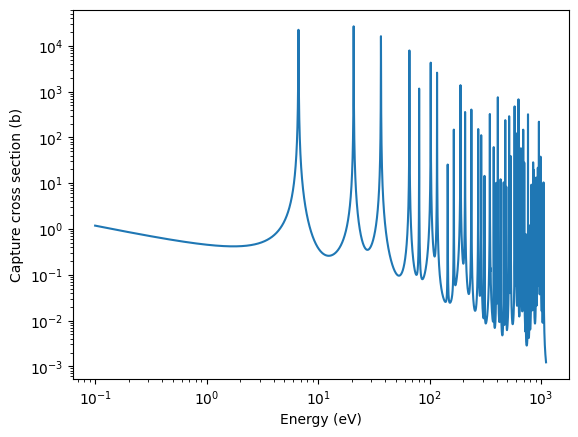

In [ ]:
I=0.0
A=238
#energy in eV
E=np.logspace(-1, np.log10(E0s[-1]*1.05), 10000) #take the upper limit as 105% of 
                                                  #the highest resonance energy in the list
    
sigma_g = np.zeros_like(E)

for E0,J,GN,GG in zip(E0s,Js,GNs,GGs):
    G=GN+GG                  #total line width
    g = (2*J+1)/(2*(2*I+1))  #statistical spin factor

    sigma_0 = 2.608e6*(A +1)**2/(A**2*E0)*g*GN/G
    y = 2/G*(E-E0)
    sigma_s += sigma_0*GG/G*np.sqrt(E0/E)*1.0/(1.0+y**2)

plt.figure()
plt.loglog(E, sigma_g)
plt.xlabel('Energy (eV)')
plt.ylabel('Capture cross section (b)')            
plt.show()

# The resonance model of elastic scattering

Now, we continue following the description of the Duderstadt and Hamilton book, and look into the reconstruction of the elastic scattering cross section.

The scattering cross section has three components
1. Resonance scattering: when the neutron is first absorbed, a compound nucleus is formed, and then reemitted while the target nucleus returns to its ground date
2. potential scattering: when the neutron is not penetrating the nuclear surface, just scatters of the nuclear potential; this process is characterized by an energy-independent cross section, comparable to the geometric cross section of the target nucleus.
3. interference scattering: due to the interference of resonance and potential scattering.

The formula for the scattering cross section is given as

$$
\sigma_s(E)=\sigma_0\frac{\Gamma_n}{\Gamma}\Big(\frac{E_0}{E}\Big)^{1/2}\frac{1}{1+y^2}+\sigma_0\frac{2R}{ \bar{\lambda} }\frac{y}{1+y^2}+4\pi R^2
$$

where the neutron wavelength is

$$\lambda=\frac{h}{\sqrt{2mE}}=\frac{2.86\cdot 10^{-9}}{\sqrt{E}(eV)}cm$$

and the reduced wavelength is

$$\bar{\lambda}=\frac{\lambda}{2\pi}$$

and for R we can use the "scattering length" from the interpreted ENDF tape, which has $10^{-12}$ cm units (as can be seen from the units given for the potential scattering cross section (`4*pi*AP**2: 11.2934 barns`).

We will follow the previous procedure to reconstruct the elastic scattering cross section. Look out that you do not need to add on the potential scattering term within the loop when iterating through each resonance (since then you would end up adding it 50 times.

In [ ]:
#Complete the cell to reconstruct the scattering cross section.
R=9.48e-13 #cm
sigma_p=11.2934 #barns
lambda_cm = 2.86e-9 / np.sqrt(E)    # cm
lbar = lambda_cm / (2.0 * np.pi)    # cm
sigma_s = np.zeros_like(E)

for E0, J, GN, GG in zip(E0s, Js, GNs, GGs):
    G = GN + GG                         # total width
    g = (2*J + 1) / (2 * (2*I + 1))     # statistical spin factor
    sigma_0 = 2.608e6*(A +1)**2/(A**2*E0)*g
    y = 2/G*(E-E0)
    sigma_s += sigma_0*(GN/G*np.sqrt(E0/E)*1.0/(1.0+y**2) + 2*R/lbar*y/(1.0+y**2)) + 4*np.pi*R**2
    
sigma_total = sigma_s + sigma_p

NameError: name 'sigma_s' is not defined

Let us save the reconstructed into a file.

In [ ]:
np.savetxt('data/U238reconstruct.dat',np.column_stack((E,sigma_g,sigma_s)))

# Acknowledgment

The datalab was inspired by the scripts available at [Jeremy A. Roberts' github page](https://github.com/robertsj/applied_reactor_physics). 